In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

import datetime
from matplotlib.dates import date2num
from matplotlib.lines import Line2D

In [2]:
#Read in the data
df_rt = pd.read_csv("rt.csv")
df_rt.head()

,date,region,index,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests,new_tests,new_cases,new_deaths
0,3/2/2020,ME,0,1.353815,1.347229,1.135023,1.538081,68.719357,0.0,0.0,0,0,NaN,NaN,NaN
1,3/3/2020,ME,1,1.347466,1.339570,1.127512,1.514020,0.666405,0.0,0.0,0,0,NaN,NaN,NaN
2,3/4/2020,ME,2,1.343113,1.336660,1.130994,1.502090,9.447788,0.0,0.0,0,0,NaN,NaN,NaN
3,3/5/2020,ME,3,1.338407,1.334258,1.129211,1.480786,17.922689,0.0,0.0,0,0,NaN,NaN,NaN
4,3/6/2020,ME,4,1.330090,1.329534,1.152407,1.486668,19.268179,0.0,0.0,0,0,NaN,NaN,NaN


In [3]:
df_mandate = pd.read_csv("stateMandateList_v3.csv")
df_mandate.head()

,state,stateSymbol,maskDate1,isMaskRequired1,maskDate2,isMaskRequired2,maskDate3,isMaskRequired3,schoolClosure_m1,banGathering_m1,...,nonEssenBussiness_m2,travelQuarantine_m2,barClosure_m2,schoolClosure_e2,banGathering_e2,resturantLimit_e2,stayAtHome_e2,nonEssenBussiness_e2,travelQuarantine_e2,barClosure_e2
0,Alabama,AL,4/28/2020,0,7/16/2020,1.0,NaN,NaN,3/27/2020,3/27/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alaska,AK,4/20/2020,0,NaN,NaN,NaN,NaN,3/13/2020,3/20/2020,...,NaN,11/16/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arizona,AZ,3/30/2020,0,NaN,NaN,NaN,NaN,3/16/2020,3/30/2020,...,7/23/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arkansas,AR,5/4/2020,1,NaN,NaN,NaN,NaN,3/11/2020,3/26/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,California,CA,6/18/2020,1,NaN,NaN,NaN,NaN,NaN,3/16/2020,...,NaN,NaN,NaN,NaN,NaN,1/25/2020,1/25/2020,NaN,NaN,NaN


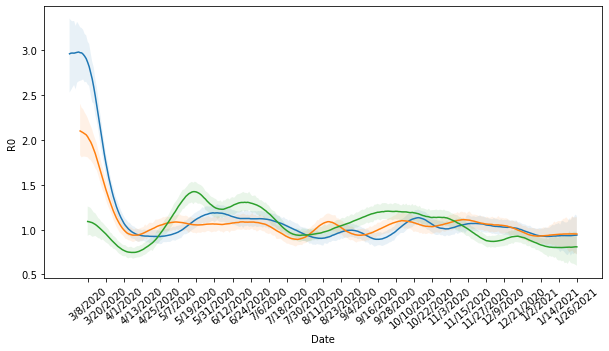

In [4]:
#Testing R0 curve 
state = ["TX", "AL", "AK"]
dateTickInterval = 12 

fig, ax = plt.subplots(figsize = (10, 5))
for name in state:
    df_rt_state = df_rt[df_rt['region'] == name]
    ax.plot(df_rt_state['date'], df_rt_state['mean'])
    ax.fill_between(df_rt_state['date'], df_rt_state['lower_80'], df_rt_state['upper_80'], alpha = .1)
    
ax.set_xlabel("Date")
ax.set_ylabel("R0")
ax.set_xticks(df_rt_state['date'][::dateTickInterval])
ax.set_xticklabels(df_rt_state['date'][::dateTickInterval], rotation=40);

if len(state) == 1:
    ax.set_title(state[0]);

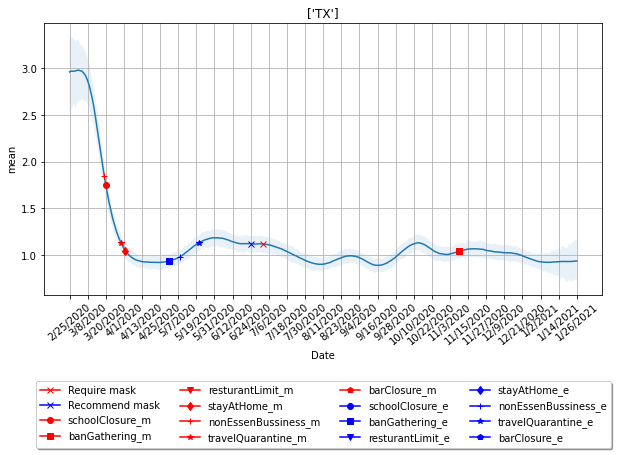

In [188]:
#Testing R0 curve with policy 
state = ["TX"]
dateTickInterval = 12 
plotTar = "mean"   #Data from "rt.csv" --> {mean, median, infection, ...}

colorDict = {"schoolClosure_m": "ro", "banGathering_m": "rs", "resturantLimit_m": "rv", "stayAtHome_m": "rd", 
             "nonEssenBussiness_m": "r+", "travelQuarantine_m": "r*", "barClosure_m": "rp",
             "schoolClosure_e": "bo", "banGathering_e": "bs", "resturantLimit_e": "bv", "stayAtHome_e": "bd", 
             "nonEssenBussiness_e": "b+", "travelQuarantine_e": "b*", "barClosure_e": "bp"}

fig, ax = plt.subplots(figsize = (10, 5))
for name in state:
    ### plot data ###
    df_rt_state = df_rt[df_rt['region'] == name]
    ax.plot(df_rt_state['date'], df_rt_state[plotTar])
    if plotTar == "mean":
        ax.fill_between(df_rt_state['date'], df_rt_state['lower_80'], df_rt_state['upper_80'], alpha = .1)
    
    ### plot mandate ###
    #mask mandate
    #round 1
    date_p = df_mandate[df_mandate['stateSymbol'] == name]['maskDate1']
    if pd.notnull(date_p).values:
        if (df_mandate[df_mandate['stateSymbol'] == name]['isMaskRequired1']).values == 0:
            ax.plot(date_p, np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_rt_state['date']).map(datetime.datetime.toordinal), 
                                      df_rt_state[plotTar]), 'bx')
        else: 
            ax.plot(date_p, np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_rt_state['date']).map(datetime.datetime.toordinal), 
                                      df_rt_state[plotTar]), 'rx')
    
    #round 2
    date_p = df_mandate[df_mandate['stateSymbol'] == name]['maskDate2']
    if pd.notnull(date_p).values:
        if (df_mandate[df_mandate['stateSymbol'] == name]['isMaskRequired2']).values == 0:
            ax.plot(date_p, np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_rt_state['date']).map(datetime.datetime.toordinal), 
                                      df_rt_state[plotTar]), 'bx')
        else: 
            ax.plot(date_p, np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_rt_state['date']).map(datetime.datetime.toordinal), 
                                      df_rt_state[plotTar]), 'rx')
    
        
    #round 3
    date_p = df_mandate[df_mandate['stateSymbol'] == name]['maskDate3']
    if pd.notnull(date_p).values:
        if (df_mandate[df_mandate['stateSymbol'] == name]['isMaskRequired3']).values == 0:
            ax.plot(date_p, np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_rt_state['date']).map(datetime.datetime.toordinal), 
                                      df_rt_state[plotTar]), 'bx')
        else: 
            ax.plot(date_p, np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_rt_state['date']).map(datetime.datetime.toordinal), 
                                      df_rt_state[plotTar]), 'rx')
    
    ## Other policy 
    columns = list(df_mandate[df_mandate['stateSymbol'] == name]) 
    for i in range(8, 36):
        date_p = df_mandate[df_mandate['stateSymbol'] == name][columns[i]]
        if pd.notnull(date_p).values:
            columnName = date_p.name[:-1:]
            ax.plot(date_p, np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_rt_state['date']).map(datetime.datetime.toordinal), 
                                      df_rt_state[plotTar]), colorDict[columnName])

### decoration ###
ax.set_xlabel("Date")
ax.set_ylabel(plotTar)
ax.set_xticks(df_rt_state['date'][::dateTickInterval])
ax.set_xticklabels(df_rt_state['date'][::dateTickInterval], rotation=40);
ax.set_title(state);
ax.grid()

## creating legend 
legend_elements = [Line2D([0], [0], color = "red", marker = "x", label = "Require mask"), 
                   Line2D([0], [0], color = "blue", marker = "x", label = "Recommend mask")]
for key in colorDict:
    legend_elements.append(Line2D([0], [0], color = colorDict[key][0], marker = colorDict[key][1], label = key))
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=4)

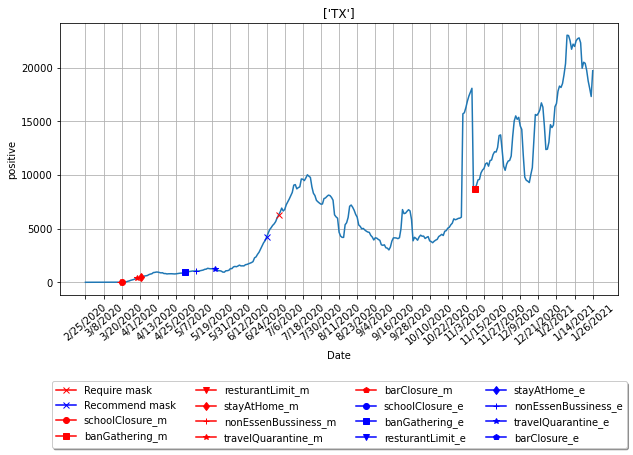

In [6]:
#Testing R0 curve with policy 
state = ["TX"]
dateTickInterval = 12 
plotTar = "positive"   #Data from "rt.csv" --> {mean, median, infection, ...}

colorDict = {"schoolClosure_m": "ro", "banGathering_m": "rs", "resturantLimit_m": "rv", "stayAtHome_m": "rd", 
             "nonEssenBussiness_m": "r+", "travelQuarantine_m": "r*", "barClosure_m": "rp",
             "schoolClosure_e": "bo", "banGathering_e": "bs", "resturantLimit_e": "bv", "stayAtHome_e": "bd", 
             "nonEssenBussiness_e": "b+", "travelQuarantine_e": "b*", "barClosure_e": "bp"}

df_rt_state = df_rt[df_rt['region'] == name]
yData =  df_rt_state[plotTar].rolling(7, min_periods=1).mean()
fig, ax = plt.subplots(figsize = (10, 5))
for name in state:
    ### plot data ###
    ax.plot(df_rt_state['date'], yData)
    if plotTar == "mean":
        ax.fill_between(df_rt_state['date'], df_rt_state['lower_80'], df_rt_state['upper_80'], alpha = .1)
    
    ### plot mandate ###
    #mask mandate
    #round 1
    date_p = df_mandate[df_mandate['stateSymbol'] == name]['maskDate1']
    if pd.notnull(date_p).values:
        if (df_mandate[df_mandate['stateSymbol'] == name]['isMaskRequired1']).values == 0:
            ax.plot(date_p, np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_rt_state['date']).map(datetime.datetime.toordinal), 
                                      yData), 'bx')
        else: 
            ax.plot(date_p, np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_rt_state['date']).map(datetime.datetime.toordinal), 
                                      yData), 'rx')
    
    #round 2
    date_p = df_mandate[df_mandate['stateSymbol'] == name]['maskDate2']
    if pd.notnull(date_p).values:
        if (df_mandate[df_mandate['stateSymbol'] == name]['isMaskRequired2']).values == 0:
            ax.plot(date_p, np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_rt_state['date']).map(datetime.datetime.toordinal), 
                                      yData), 'bx')
        else: 
            ax.plot(date_p, np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_rt_state['date']).map(datetime.datetime.toordinal), 
                                      yData), 'rx')
    
        
    #round 3
    date_p = df_mandate[df_mandate['stateSymbol'] == name]['maskDate3']
    if pd.notnull(date_p).values:
        if (df_mandate[df_mandate['stateSymbol'] == name]['isMaskRequired3']).values == 0:
            ax.plot(date_p, np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_rt_state['date']).map(datetime.datetime.toordinal), 
                                      yData), 'bx')
        else: 
            ax.plot(date_p, np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_rt_state['date']).map(datetime.datetime.toordinal), 
                                      yData), 'rx')
    
    ## Other policy 
    columns = list(df_mandate[df_mandate['stateSymbol'] == name]) 
    for i in range(8, 36):
        date_p = df_mandate[df_mandate['stateSymbol'] == name][columns[i]]
        if pd.notnull(date_p).values:
            columnName = date_p.name[:-1:]
            ax.plot(date_p, np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_rt_state['date']).map(datetime.datetime.toordinal), 
                                      yData), colorDict[columnName])

### decoration ###
ax.set_xlabel("Date")
ax.set_ylabel(plotTar)
ax.set_xticks(df_rt_state['date'][::dateTickInterval])
ax.set_xticklabels(df_rt_state['date'][::dateTickInterval], rotation=40);
ax.set_title(state);
ax.grid()

## creating legend 
legend_elements = [Line2D([0], [0], color = "red", marker = "x", label = "Require mask"), 
                   Line2D([0], [0], color = "blue", marker = "x", label = "Recommend mask")]
for key in colorDict:
    legend_elements.append(Line2D([0], [0], color = colorDict[key][0], marker = colorDict[key][1], label = key))
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=4)

In [7]:
###
dirFile = glob.glob(os.path.join("data", "USData", "*.csv"))
#check file
df = pd.read_csv(dirFile[0])
df.head()
df_rt_state = df_rt[df_rt['region'] == name]
yData =  df_rt_state[plotTar].rolling(7, min_periods=1).mean()
frames=[]
for file in dirFile:
    df=pd.read_csv(file)
    df['date']=pd.to_datetime(df['date'])
    df=df.fillna(0)
    df=df.sort_values(by='date',ascending=True)
    frames.append(df)
final=pd.concat(frames)

C:\Users\ken\miniconda3\envs\datathon\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\ken\miniconda3\envs\datathon\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


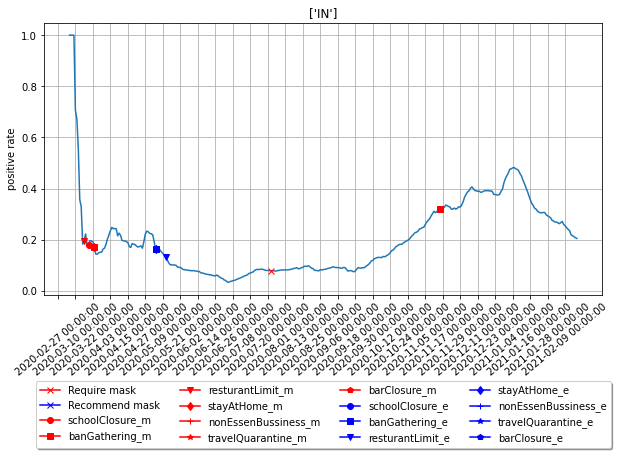

In [83]:
#Testing POSITIVE RATE with policy 
state = ["IN"]
dateTickInterval = 12 
plotTar = "positive rate"   #Data from "rt.csv" --> {mean, median, infection, ...}

colorDict = {"schoolClosure_m": "ro", "banGathering_m": "rs", "resturantLimit_m": "rv", "stayAtHome_m": "rd", 
             "nonEssenBussiness_m": "r+", "travelQuarantine_m": "r*", "barClosure_m": "rp",
             "schoolClosure_e": "bo", "banGathering_e": "bs", "resturantLimit_e": "bv", "stayAtHome_e": "bd", 
             "nonEssenBussiness_e": "b+", "travelQuarantine_e": "b*", "barClosure_e": "bp"}

fig, ax = plt.subplots(figsize = (10, 5))

for name in state:
    df_temp = final[final['state'] == name]
    df_temp.positiveIncrease = df_temp.positiveIncrease.mask(df_temp.positiveIncrease.lt(0),0)
    df_temp.negativeIncrease = df_temp.negativeIncrease.mask(df_temp.negativeIncrease.lt(0),0)
    
    #df_temp['date'] = pd.to_datetime(df_temp['date'])
    
    yData =  (df_temp['positiveIncrease']/(df_temp['positiveIncrease'] + df_temp['negativeIncrease'])).rolling(7, min_periods=1).mean()
    
    ### plot data ###
    ax.plot(df_temp['date'], yData)
    ### plot mandate ###
    #mask mandate
    #round 1
    date_p = df_mandate[df_mandate['stateSymbol'] == name]['maskDate1']
    if pd.notnull(date_p).values:
        if (df_mandate[df_mandate['stateSymbol'] == name]['isMaskRequired1']).values == 0:
            ax.plot(pd.to_datetime(date_p), np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_temp['date']).map(datetime.datetime.toordinal), 
                                      yData), 'bx')
        else: 
            ax.plot(pd.to_datetime(date_p), np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_temp['date']).map(datetime.datetime.toordinal), 
                                      yData), 'rx')

            

    #round 2
    date_p = df_mandate[df_mandate['stateSymbol'] == name]['maskDate2']
    if pd.notnull(date_p).values:
        if (df_mandate[df_mandate['stateSymbol'] == name]['isMaskRequired2']).values == 0:
            ax.plot(pd.to_datetime(date_p), np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_temp['date']).map(datetime.datetime.toordinal), 
                                      yData), 'bx')
        else: 
            ax.plot(pd.to_datetime(date_p), np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_temp['date']).map(datetime.datetime.toordinal), 
                                      yData), 'rx')
    
        
    #round 3
    date_p = df_mandate[df_mandate['stateSymbol'] == name]['maskDate3']
    if pd.notnull(date_p).values:
        if (df_mandate[df_mandate['stateSymbol'] == name]['isMaskRequired3']).values == 0:
            ax.plot(pd.to_datetime(date_p), np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_temp['date']).map(datetime.datetime.toordinal), 
                                      yData), 'bx')
        else: 
            ax.plot(pd.to_datetime(date_p), np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_temp['date']).map(datetime.datetime.toordinal), 
                                      yData), 'rx')
            
    ## Other policy 
    columns = list(df_mandate[df_mandate['stateSymbol'] == name]) 
    for i in range(8, 36):
        date_p = df_mandate[df_mandate['stateSymbol'] == name][columns[i]]
        if pd.notnull(date_p).values:
            columnName = date_p.name[:-1:]
            ax.plot(pd.to_datetime(date_p), np.interp(pd.to_datetime(date_p).map(datetime.datetime.toordinal), 
                                      pd.to_datetime(df_temp['date']).map(datetime.datetime.toordinal), 
                                      yData), colorDict[columnName])

### decoration ###


ax.set_xlabel("Date")
ax.set_ylabel(plotTar)
ax.set_xticks(df_temp['date'][::dateTickInterval])
ax.set_xticklabels(df_temp['date'][::dateTickInterval], rotation=40);

ax.set_title(state);
ax.grid()

## creating legend 
legend_elements = [Line2D([0], [0], color = "red", marker = "x", label = "Require mask"), 
                   Line2D([0], [0], color = "blue", marker = "x", label = "Recommend mask")]
for key in colorDict:
    legend_elements.append(Line2D([0], [0], color = colorDict[key][0], marker = colorDict[key][1], label = key))
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=4)


In [201]:
## Analysis positive rate
noPositiveRate = final.groupby('state')['negativeIncrease'].agg(sum)
#print("****State that we could not compute positive rate****")
#print(list(x[x == 0].index.values))

STATE_NAME_WITH_TREAT = []
INDEX_WITH_TREAT = []

STATE_NAME_WO_TREAT = []
INDEX_WO_TREAT = []

startDate = '2020-09-01'
endDate = '2021-01-01'

#check if mandate would actually reduce the positive rate (over a month)
for state in final['state'].unique():
    if state in noPositiveRate[noPositiveRate == 0].index.values:
        #print(state + " missing data: cannot compute positive rate")
        continue
    #Have second lock down
    if state not in ["AL", "DE", "FL", "GA", "KS", "MO", "UT", "WI"]: 
        #masking data 
        df_temp = final[final['state'] == state]
        mask = (df_temp['date'] > startDate) & (df_temp['date'] <= endDate)
        df_temp = df_temp.loc[mask]
        
        #compute positive rate
        df_temp.positiveIncrease = df_temp.positiveIncrease.mask(df_temp.positiveIncrease.lt(0),0)
        df_temp.negativeIncrease = df_temp.negativeIncrease.mask(df_temp.negativeIncrease.lt(0),0)
    
        avgPosRate =  (df_temp['positiveIncrease']/(df_temp['positiveIncrease'] + df_temp['negativeIncrease'])).rolling(7, min_periods=1).mean().mean()
    
        STATE_NAME_WITH_TREAT.append(state)
        INDEX_WITH_TREAT.append(avgPosRate)
    else:
        print(state + " does not have second lockdown")
                #masking data 
        df_temp = final[final['state'] == state]
        mask = (df_temp['date'] > startDate) & (df_temp['date'] <= endDate)
        df_temp = df_temp.loc[mask]
        
        #compute positive rate
        df_temp.positiveIncrease = df_temp.positiveIncrease.mask(df_temp.positiveIncrease.lt(0),0)
        df_temp.negativeIncrease = df_temp.negativeIncrease.mask(df_temp.negativeIncrease.lt(0),0)
    
        avgPosRate =  (df_temp['positiveIncrease']/(df_temp['positiveIncrease'] + df_temp['negativeIncrease'])).rolling(7, min_periods=1).mean().mean()
    
        STATE_NAME_WO_TREAT.append(state)
        INDEX_WO_TREAT.append(avgPosRate)

AL does not have second lockdown
DE does not have second lockdown
FL does not have second lockdown
KS does not have second lockdown
MO does not have second lockdown
UT does not have second lockdown
WI does not have second lockdown


In [202]:
from scipy.stats import ttest_ind
t, p = ttest_ind(INDEX_WITH_TREAT, INDEX_WO_TREAT, equal_var = False)
print(p)

0.696051998752512


In [203]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(INDEX_WITH_TREAT, INDEX_WO_TREAT)
print(p)

0.20329479722076305


In [237]:
## Analysis R0 

STATE_NAME_WITH_TREAT = []
INDEX_WITH_TREAT = []

STATE_NAME_WO_TREAT = []
INDEX_WO_TREAT = []

startDate = '2020-09-01'
endDate = '2021-01-01'

#check if mandate would actually reduce the positive rate (over a month)
for state in final['state'].unique():
    #Have second lock down
    if state not in ["AL", "DE", "FL", "GA", "KS", "MO", "UT", "WI"]: 
        #masking data 
        df_temp = df_rt[df_rt['region'] == state]
        df_temp['date'] = pd.to_datetime(df_temp['date']) 
        mask = (df_temp['date'] > startDate) & (df_temp['date'] <= endDate)
        df_temp = df_temp.loc[mask]
        
        if np.isnan(df_temp['mean'].mean(skipna = True)): 
            continue 
            
        STATE_NAME_WITH_TREAT.append(state)
        INDEX_WITH_TREAT.append(df_temp['mean'].mean(skipna = True))
    else:
        print(state + " does not have second lockdown")
        #masking data 
        df_temp = df_rt[df_rt['region'] == state]
        df_temp['date'] = pd.to_datetime(df_temp['date']) 
        mask = (df_temp['date'] > startDate) & (df_temp['date'] <= endDate)
        df_temp = df_temp.loc[mask]
        
        STATE_NAME_WO_TREAT.append(state)
        INDEX_WO_TREAT.append(df_temp['mean'].mean(skipna = True))

AL does not have second lockdown
DE does not have second lockdown


<ipython-input-237-583594437b21>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['date'] = pd.to_datetime(df_temp['date'])
<ipython-input-237-583594437b21>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['date'] = pd.to_datetime(df_temp['date'])


FL does not have second lockdown
GA does not have second lockdown
KS does not have second lockdown
MO does not have second lockdown
UT does not have second lockdown
WI does not have second lockdown


In [238]:
from scipy.stats import ttest_ind
t, p = ttest_ind(INDEX_WITH_TREAT, INDEX_WO_TREAT, equal_var = False)
print(p)

0.016717594229787185


In [239]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(INDEX_WITH_TREAT, INDEX_WO_TREAT)
print(p)

0.042499490105414706
